In [120]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from pint import UnitRegistry
import plotly.graph_objects as go
ureg = UnitRegistry()
Q = ureg.Quantity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timer Frequency

Reference Manual 0365

pg 555

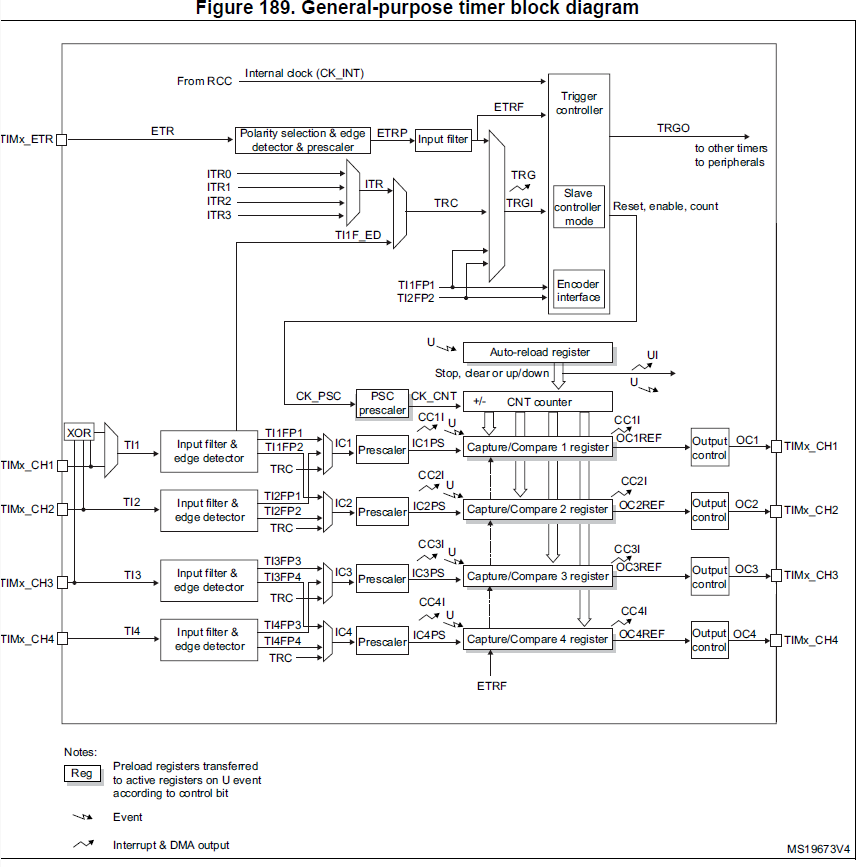

pg 119

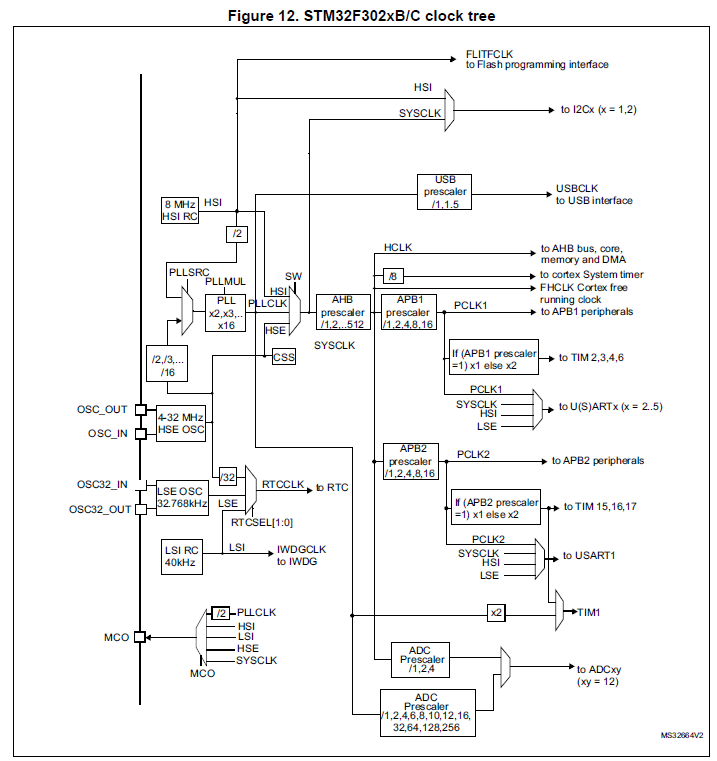

- `CK_PSC` = Clock input to timer before presaler
- `CK_CNT` = Clock Counter after prescaler

$$
\begin{align}
T_{\text{CK\_CNT}} &= (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
\frac{1}{f_{\text{CK\_CNT}}} &= \frac{\text{PSC} + 1}{f_{\text{CK\_PSC}}} \\
f_{\text{CK\_CNT}} &= \frac{f_{\text{CK\_PSC}}}{\text{PSC} + 1} \\
\end{align}
$$

We are using the internal clock `CK_INT` in our application, so we have

$$
\begin{align}
T_{\text{CK\_PSC}} &= T_{\text{CK\_INT}} \\
f_{\text{CK\_PSC}} &= f_{\text{CK\_INT}} \\
\end{align}
$$

To convert between counts, $n$, and the duration it takes for the counter to reach that value $T_n$, we have

$$
\begin{align}
T_n &= n T_{\text{CK\_CNT}} \\
T_n &= n (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
T_n &= \frac{n (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\end{align}
$$

and a desired $n$ value may be found using

$$
\begin{align}
T_n f_{\text{CK\_PSC}} &= n (\text{PSC} + 1) \\
n &= \frac{T_n f_{\text{CK\_PSC}}}{\text{PSC} + 1} \\
\end{align}
$$

In [121]:
def calc_Tn_from_counts(n, PSC, f_CK_PSC):
    return (n * (PSC + 1)) / f_CK_PSC

def calc_counts_from_Tn(Tn, PSC, f_CK_PSC):
    return round((Tn * f_CK_PSC) / (PSC + 1))

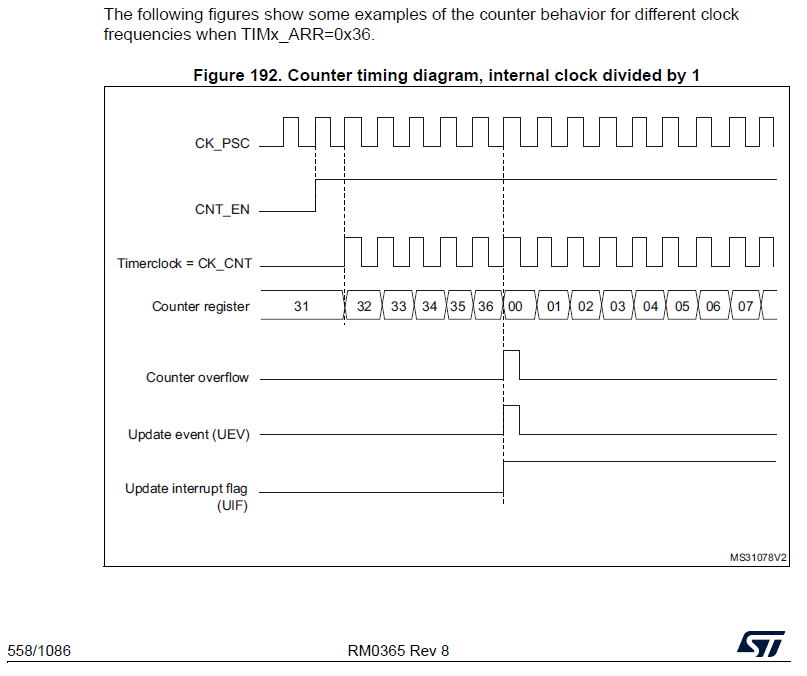

The timer resets and issues an update event `UEV` when the counter counts up to and includes `ARR` after counting up from zero. In this case, $n=\text{ARR} + 1$ and so

$$
\begin{align}
T_{\text{UEV}} &= \frac{(\text{ARR} + 1) (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\end{align}
$$

The Timer reset frequency can then be found

$$
\begin{align}
\frac{1}{f_{\text{UEV}}} &= \frac{(\text{ARR} + 1) (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
f_{\text{UEV}} &= \frac{f_{\text{CK\_PSC}}}{(\text{ARR} + 1) (\text{PSC} + 1)} \\
\end{align}
$$

In the reverse case if target $f_{\text{UEV}}$, `CK_PSC`, and `PSC` is known, we can find associated `ARR`

$$
\begin{align}
\frac{f_{\text{UEV}} (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} &= \frac{1}{(\text{ARR} + 1) } \\
\text{ARR} + 1 &= \frac{f_{\text{CK\_PSC}}}{f_{\text{UEV}} (\text{PSC} + 1)} \\
\text{ARR} &= \frac{f_{\text{CK\_PSC}}}{f_{\text{UEV}} (\text{PSC} + 1)} - 1 \\
\end{align}
$$

In [122]:
def calc_T_UEV(ARR, PSC, f_CK_PSC):
    return calc_Tn_from_counts(n=ARR+1, PSC=PSC, f_CK_PSC=f_CK_PSC)

def calc_f_UEV(f_CK_PSC, PSC, ARR):
    return f_CK_PSC / ((ARR + 1) * (PSC + 1))

def calc_ARR(f_UEV, f_CK_PSC, PSC):
    return round((f_CK_PSC / (f_UEV * (PSC + 1))) - 1)

In [123]:
f_CK_PSC = Q(64e6, 'Hz')
PSC = 0

ARR_mic = 4000
f_UEV_mic = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR_mic).to('Hz')
T_UEV_mic = calc_T_UEV(ARR=ARR_mic, PSC=PSC, f_CK_PSC=f_CK_PSC).to('us')
print(f"When ARR_mic is {ARR_mic}, f_UEV_mic={f_UEV_mic:.0f}, T_UEV_mic={T_UEV_mic:.3f}")

When ARR_mic is 4000, f_UEV_mic=15996 hertz, T_UEV_mic=62.516 microsecond


# Addressable LED Pulse Study

In PWM mode, we are concerned with the duration of the output pulse before reaching the `CCR` value.

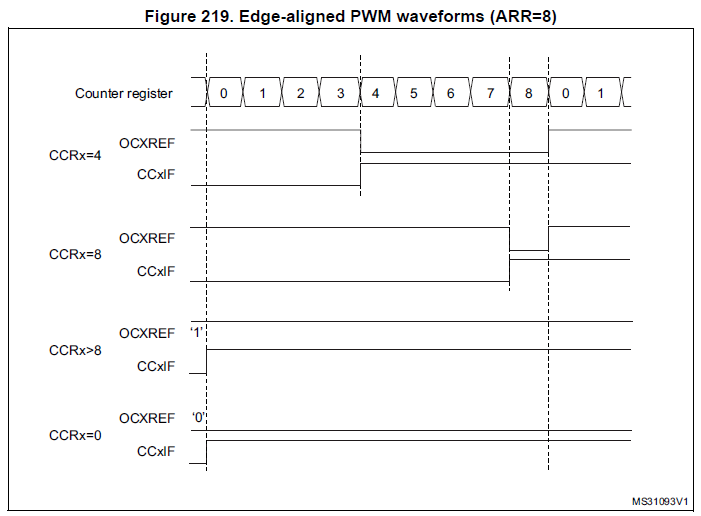

Unlike the `ARR` and `PSC` register usage, the output changes sign *at the start* of when the counter reaches the `CCR` value.  In this case, a pulse with duration $T_{\text{PULSE}}$ would then change state when $n = \text{CCR}$ is reached.

$$
\begin{align}
T_{\text{PULSE}} &= \text{CCR} T_{\text{CK\_CNT}} \\
T_{\text{PULSE}} &= \text{CCR} (\text{PSC} + 1) T_{\text{CK\_PSC}} \\
T_{\text{PULSE}} &= \frac{\text{CCR} (\text{PSC} + 1)}{f_{\text{CK\_PSC}}} \\
\end{align}
$$

Similarly, the `CCR` value for a desired $T_{\text{PULSE}}$ can be found

$$
\begin{align}
\text{CCR} &= \frac{T_{\text{PULSE}}}{(\text{PSC} + 1) T_{\text{CK\_PSC}}} \\
\text{CCR} &= \frac{T_{\text{PULSE}} f_{\text{CK\_PSC}}}{(\text{PSC} + 1)} \\
\end{align}
$$

For this project, I am likely using this one: https://www.adafruit.com/product/3919

- 0.5 m * 60 LEDs/m = 30 LEDs per strip
- SK6812 LEDs used: https://cdn-shop.adafruit.com/product-files/1138/SK6812+LED+datasheet+.pdf

In [124]:
f_UEV_led_ideal = Q(800e3, 'Hz')
ARR_led = calc_ARR(f_UEV=f_UEV_led_ideal, f_CK_PSC=f_CK_PSC, PSC=PSC)
f_UEV_led = calc_f_UEV(f_CK_PSC=f_CK_PSC, PSC=PSC, ARR=ARR_led)
T_UEV_led = calc_T_UEV(ARR=ARR_led, PSC=PSC, f_CK_PSC=f_CK_PSC).to('ns')
print(f"When ARR_led set to {ARR_led.magnitude:.0f}, f_UEV_led={f_UEV_led:.0f}, T_UEV_led={T_UEV_led:.3f}")

for T_PULSE_ideal in Q([300, 600], 'nsec'):
    CCR = round(calc_counts_from_Tn(T_PULSE_ideal, PSC, f_CK_PSC).to('')) # need to re-round with dimension change
    T_PULSE = calc_Tn_from_counts(CCR, PSC, f_CK_PSC)
    print(f"When CCR is {CCR.magnitude:.0f}, T_PULSE is {T_PULSE.to('nsec'):.3f} (closest to {T_PULSE_ideal.to('nsec'):.3f})")

When ARR_led set to 79, f_UEV_led=800000 hertz, T_UEV_led=1250.000 nanosecond
When CCR is 19, T_PULSE is 296.875 nanosecond (closest to 300.000 nanosecond)
When CCR is 38, T_PULSE is 593.750 nanosecond (closest to 600.000 nanosecond)


# Refresh Rate

In [125]:
n_channels = 3
T_write_single = n_channels * 8 * calc_T_UEV(ARR=ARR_led, PSC=PSC, f_CK_PSC=f_CK_PSC)
print(f"Time to write single LED is {T_write_single.to('usec'):.3f}")

n_LEDs = 30+20
T_write_n_LEDs = n_LEDs * T_write_single
print(f"Time to write {n_LEDs} LEDs is {T_write_n_LEDs.to('msec'):.3f} (Maximum update frequency is {1/T_write_n_LEDs:.0f})")

Time to write single LED is 30.000 microsecond
Time to write 50 LEDs is 1.500 millisecond (Maximum update frequency is 667 hertz)


In [126]:
n_mic_samples = 1000
T_read_single = n_mic_samples * calc_T_UEV(ARR=ARR_mic, PSC=PSC, f_CK_PSC=f_CK_PSC)
print(f"Time to sample microphone {n_mic_samples} times: T_read_single={T_read_single.to('msec'):.3f}")

Time to sample microphone 1000 times: T_read_single=62.516 millisecond


In [127]:
n_config = 2000 # SWAG
T_config = calc_Tn_from_counts(n=n_config, PSC=PSC, f_CK_PSC=f_CK_PSC)
print(f"If it takes {n_config} timer counts for configuring leds and mic each time controller cycles states, then T_config={T_config.to('msec'):.3f}")

If it takes 2000 timer counts for configuring leds and mic each time controller cycles states, then T_config=0.031 millisecond


In [128]:
T_total = T_write_n_LEDs + T_read_single + T_config
f_total = 1/T_total
print(f"Refresh Rate: f_total={f_total:.0f} (T_total={T_total.to('msec'):.3f})")

Refresh Rate: f_total=16 hertz (T_total=64.047 millisecond)


# Buck Converter

https://www.ti.com/lit/ds/symlink/tps565201.pdf

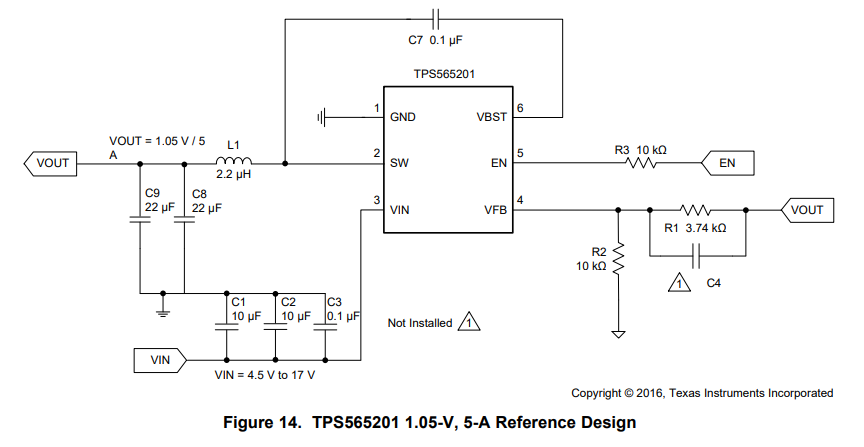

In [129]:
V_out = Q(5.0, 'V')
V_in_max = Q(14, 'V')
L_out = Q(3.3, 'uH')
f_sw = Q(550, 'kHz')
I_out = Q(4, 'A') # Conservative, expecting around 2 A
C_out = Q(22+22, 'uF')
C_zero = Q(1, 'nF')

## Resistor Selection

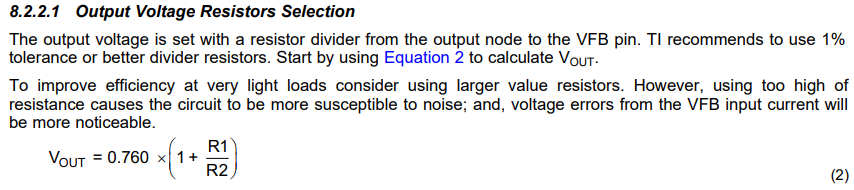

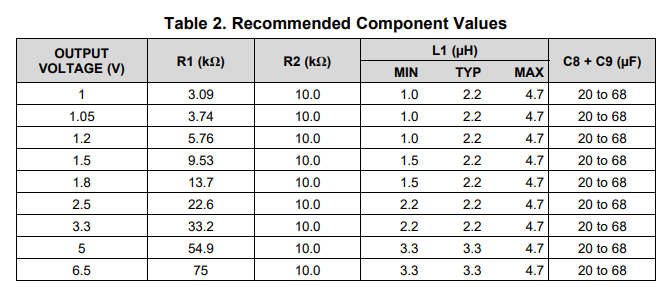

In [130]:
Vout = 0.760 * (1 + 54.9e3 / 10e3)
print(f"Vout={Vout:.3f}")

Vout=4.932


## Output Inductor

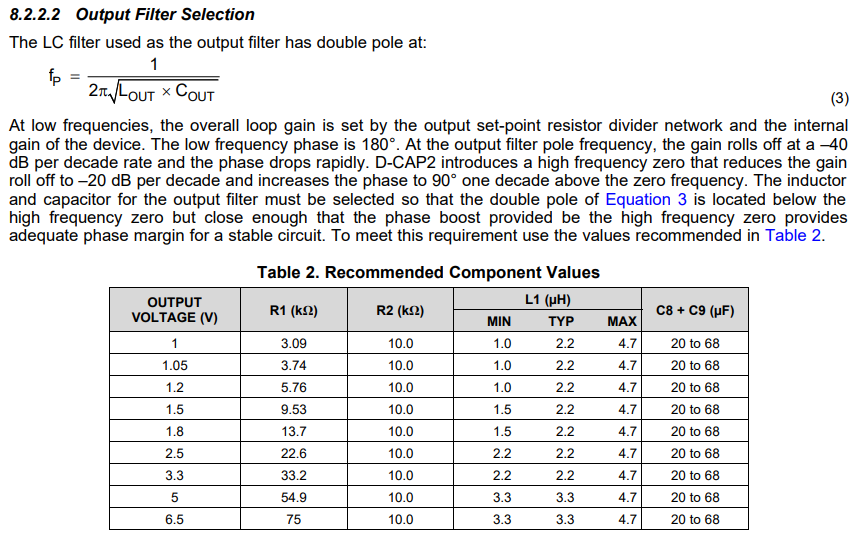

In [131]:
fp = 1 / (2 * np.pi * np.sqrt(L_out * C_out))
fz = 1 / (2 * np.pi * Q(10, 'kohm') * C_zero)
print(f"Double pole at fp={fp.to('kHz'):.3f}, zero at fz={fz.to('kHz'):.3f}")

Double pole at fp=13.208 kilohertz, zero at fz=15.915 kilohertz


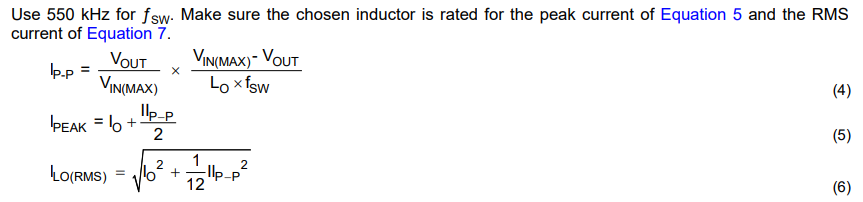

In [132]:
IPP =(V_out / V_in_max) * ( (V_in_max - V_out) / (L_out * f_sw) )
IPEAK = I_out + (IPP / 2)
I_L_out_rms = np.sqrt(I_out**2 + (1/12)*IPP**2)
print(f"IPP={IPP.to('A'):.3f}, IPEAK={IPEAK.to('A'):.3f}, I_L_out_rms={I_L_out_rms.to('A'):.3f}")


IPP=1.771 ampere, IPEAK=4.885 ampere, I_L_out_rms=4.033 ampere


The inductor

- saturation current rating must be greater than the calculated peak current and 
- the RMS or heating current rating must be greater than the calculated RMS current

https://www.bourns.com/docs/Product-Datasheets/SRN8040.pdf

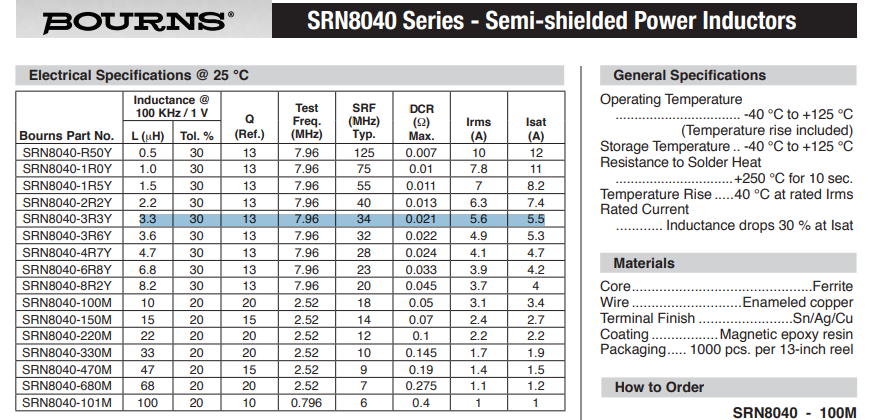

## Output Capacitor

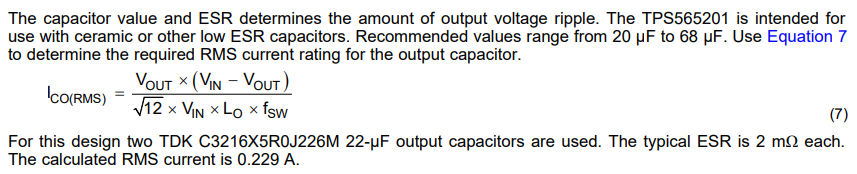

In [133]:
I_C_out_rms = (V_out * (V_in_max - V_out)) / (np.sqrt(12) * V_in_max * L_out * f_sw)
print(f"I_C_out_rms={I_C_out_rms.to('A'):.3f}")

I_C_out_rms=0.511 ampere


# DSP

Items below use scipy signal tools to estimate frequency response of various filters.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html

$$
\begin{align}
a[0] y[n] + a[1] y[n-1] + a[2] y[n-2] + \dots = b[0] x[n] + b[1] x[n-1] + b[2] x[n-2] + \dots \\
\end{align}
$$

In [134]:
print(f"When ARR_mic is {ARR_mic}, f_UEV_mic={f_UEV_mic:.0f}, T_UEV_mic={T_UEV_mic:.3f}")

def calc_tau_from_f0(f0):
    return 1 / (2 * np.pi * f0)

def calc_f0_from_tau(tau):
    return 1 / (2 * np.pi * tau)

def plot_frequency_response(w, h):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=w, y=20*np.log10(abs(h)), mode='lines', name='Magnitude (dB)', yaxis='y1'))
    fig.add_trace(go.Scatter(x=w, y=np.angle(h)*180/np.pi, mode='lines', name='Phase (deg)', yaxis='y2'))

    fig.update_layout(
        title='Frequency Response',
        xaxis_title='Frequency (Hz)',
        yaxis=dict(
            title='Magnitude (dB)',
            side='left'
        ),
        yaxis2=dict(
            title='Phase (degrees)',
            overlaying='y',
            side='right'
        ),
        legend_title='Response Type'
    )

    fig.show()

When ARR_mic is 4000, f_UEV_mic=15996 hertz, T_UEV_mic=62.516 microsecond


## Lowpass Filter

In [135]:
tau_lpf = Q(1.0, 'msec')
f0_lpf = calc_f0_from_tau(tau_lpf).to('Hz')
print(f"tau_lpf={tau_lpf:.3f}, f0_lpf={f0_lpf:.3f}")
tau_over_T_lpf = (tau_lpf / T_UEV_mic).to('')
print(f"tau_over_T_lpf={tau_over_T_lpf:.3f}")

w, h = sp.signal.freqz(
    b=[1],
    a=[tau_over_T_lpf+1, -tau_over_T_lpf],
    worN=1000,
    fs=f_UEV_mic.magnitude,
    plot=plot_frequency_response
)

tau_lpf=1.000 millisecond, f0_lpf=159.155 hertz
tau_over_T_lpf=15.996 dimensionless


## Highpass Filter

In [136]:
tau_hpf = Q(1.0, 'msec')
f0_hpf = calc_f0_from_tau(tau_hpf).to('Hz')
print(f"tau_hpf={tau_hpf:.3f}, f0_hpf={f0_hpf:.3f}")
tau_over_T_hpf = (tau_hpf / T_UEV_mic).to('')
print(f"tau_over_T_hpf={tau_over_T_hpf:.3f}")

w, h = sp.signal.freqz(
    b=[tau_over_T_hpf, -tau_over_T_hpf],
    a=[tau_over_T_hpf+1, -tau_over_T_hpf],
    worN=1000,
    fs=f_UEV_mic.magnitude,
    plot=plot_frequency_response
)

tau_hpf=1.000 millisecond, f0_hpf=159.155 hertz
tau_over_T_hpf=15.996 dimensionless


C:\Users\neilf\AppData\Local\Temp\ipykernel_20568\755890957.py:11: RuntimeWarning:

divide by zero encountered in log10



## First Difference Differentiator

In [137]:
w, h = sp.signal.freqz(
    b=[1, -1],
    a=[1],
    fs=f_UEV_mic.magnitude,
    plot=plot_frequency_response
)

C:\Users\neilf\AppData\Local\Temp\ipykernel_20568\755890957.py:11: RuntimeWarning:

divide by zero encountered in log10

